# Lab 1

## What we're going to cover
- Jupyter speedrun
- What Qiskit offers and the Qiskit stack
- State preparation
- Superdense coding
- Quantum teleportation
    <!-- - Superdense coding
    - Deutsch algorithm
    - Classical query complexity of the Deutsch-Josza algorithm -->

## Jupyter, but really fast

In [1]:
print("This is Python code in a cell, it gets executed when the cell runs")
"The last thing executed in a cell is 'output.'"

This is Python code in a cell, it gets executed when the cell runs


"The last thing executed in a cell is 'output.'"

In [2]:
Out  # and Jupyter remembers it!

{1: "The last thing executed in a cell is 'output.'"}

In [3]:
assert not (9 + 10 == 21)
# assert 9 + 10 == 21, "duH"

In [4]:
foo = 10

In [5]:
foo + 2

12

In [6]:
foo -= 100

In [7]:
def add1(x):
    return x + 1

In [8]:
add1(foo)

-89

In [9]:
# import pprint as pp

## Qiskit

### Main Python Imports

In [10]:
# Do the necessary imports
import numpy as np
from math import sqrt, log2

import qiskit
qiskit.__version__

'2.0.0'

### About Qiskit and its packages...
[IBM docs link](https://qiskit.org/documentation/the_elements.html#terra) with more details and precise language.

[Qiskit main docs](https://qiskit.org/documentation/index.html), where Qiskit's services are split into 3 main components:
 1. SDK - software development kit (the python code we will be using today)
 2. Runtime - circuit execution and scheduling (think batching jobs)
 3. Transpiler - reformats circuits to work with the IBM's hardware

We usually only focus on 1. 

### State Preparation

In [11]:
# Returns a pretty string representation of the input 2-D statevector
def get_braket_string(statevector):
    num_qubits = log2(len(statevector))
    assert num_qubits.is_integer(), 'Expected a 2**n state'
    num_qubits = int(num_qubits)
    
    assert abs(np.linalg.norm(statevector) - 1) < 1e-4, 'Norm of state is too far from 1'
    
    
    simpler_state = []
    # discards 0 values
    for amplitude in statevector:
        if amplitude.imag == 0 and amplitude.real == 0:
            simpler_state.append(0)
        elif amplitude.imag == 0:
            simpler_state.append(amplitude.real)
        elif amplitude.real == 0:
            simpler_state.append(amplitude.imag)
        else:
            simpler_state.append(amplitude)


    out_str = ''
    skip_plus = False
    for index, amplitude in enumerate(simpler_state):
        if amplitude == 0:
            skip_plus = True
            continue
        
        if not skip_plus and index > 0:
            out_str += '+'

        state = format(index, f'0{num_qubits}b')
        
        # g defaults to 6 digits of precision but ignores zeros        
        out_str += f'{amplitude : g}|{state}>'
    return out_str

Approx state length = 1.0


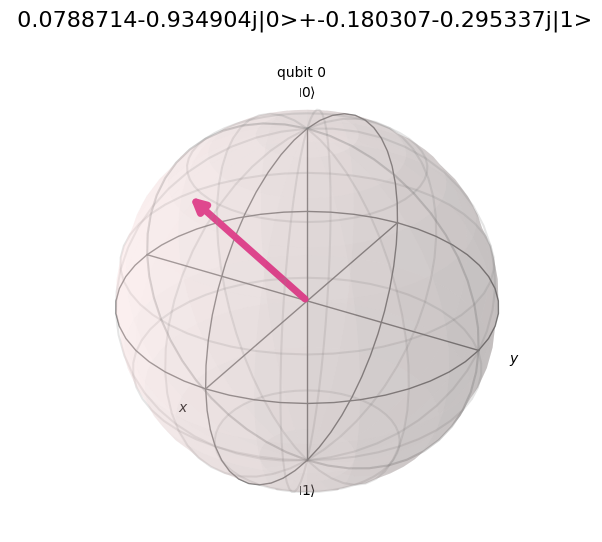

In [12]:
from qiskit.quantum_info import random_statevector
from qiskit.visualization import plot_bloch_multivector

# Create random 1-qubit state
psi = random_statevector(2)
print(f'Approx state length = {np.linalg.norm(psi)}') # check its length

# Plot it on the bloch-sphere
plot_bloch_multivector(psi, title=get_braket_string(psi))
# WARNING: Be sure not to confuse this with plot_bloch_vector, which only works for explicit/3-D vectors

Approx state length = 1.0


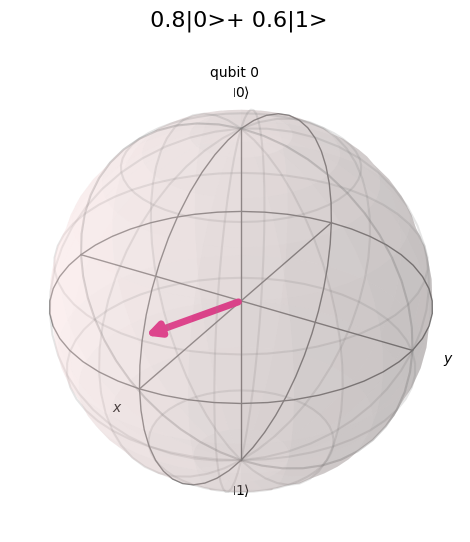

In [13]:
from qiskit.quantum_info import Statevector

# Create specifice 1-qubit state
phi = Statevector([0.8, 0.6])
print(f'Approx state length = {np.linalg.norm(phi)}') # check its length

# Plot it on the bloch-sphere
plot_bloch_multivector(phi, title=get_braket_string(phi))

In [14]:
from qiskit.circuit.library import Initialize
from qiskit.circuit import QuantumCircuit

init_gate = Initialize(phi)
init_gate.label = "init"

circ = QuantumCircuit(1)
circ.append(init_gate, [0])
circ.measure_all()
print(circ)

        ┌───────────────┐ ░ ┌─┐
     q: ┤ init(0.8,0.6) ├─░─┤M├
        └───────────────┘ ░ └╥┘
meas: 1/═════════════════════╩═
                             0 


### Circuit Basics
#### Pauli Gates, Hadamard and Barriers


and Density matrix 

In [15]:
from qiskit import QuantumRegister
from qiskit import ClassicalRegister

q = QuantumRegister(3)
c = ClassicalRegister(3)
qc= QuantumCircuit(q,c)

qc.x(q[0])
qc.y(q[1])
qc.z(q[2])

qc.barrier() # explicitly tells the compiler to avoid merging gates (don't optimize)
qc.id(q[0])
qc.h(q[2])

qc.measure(q, c)

print(qc)

      ┌───┐ ░ ┌───┐   ┌─┐   
q0_0: ┤ X ├─░─┤ I ├───┤M├───
      ├───┤ ░ └───┘┌─┐└╥┘   
q0_1: ┤ Y ├─░──────┤M├─╫────
      ├───┤ ░ ┌───┐└╥┘ ║ ┌─┐
q0_2: ┤ Z ├─░─┤ H ├─╫──╫─┤M├
      └───┘ ░ └───┘ ║  ║ └╥┘
c0: 3/══════════════╩══╩══╩═
                    1  0  2 


### Executing Circuits

Read more about Qiskit's Aer simulator here: https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.AerSimulator.html

Takeaways:
  1. You can provide global run settings, or specify them for each run.
  2. You can mimic an IBM backend.
  3. Because this runs a *classical* simulation, you can use save_state to insert snapshots into your circuit
            and learn more about the statevector in the middle of a program

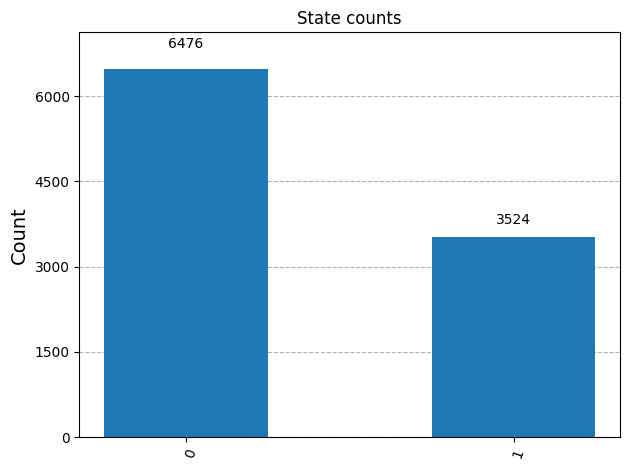

In [16]:
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

simulator = AerSimulator()

result = simulator.run(circ,shots=10000).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='State counts')

Approx state length = 1.0


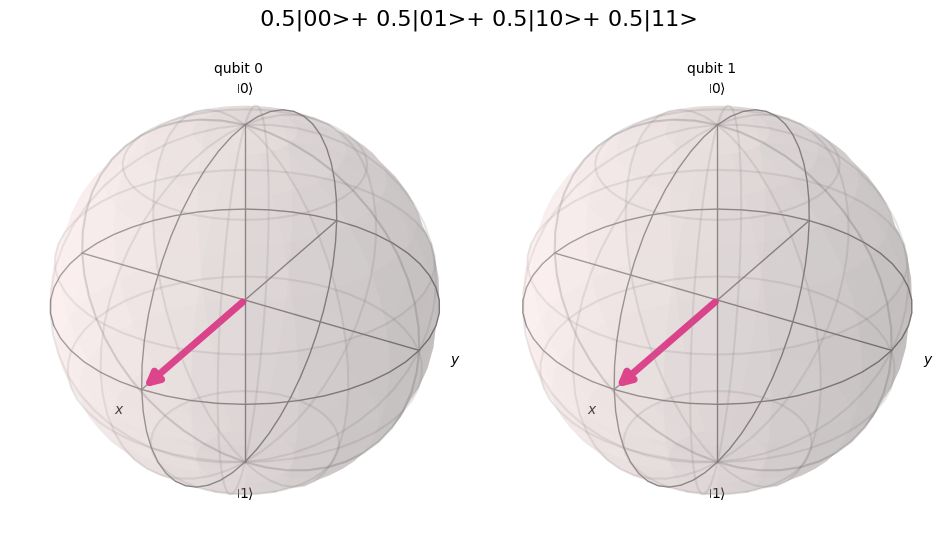

In [17]:
from qiskit.quantum_info import Statevector

# Create specific 2-qubit state
phi = Statevector([0.5, 0.5,0.5, 0.5])
#phi = Statevector([1/sqrt(2), 0,0, 1/sqrt(2)])

print(f'Approx state length = {np.linalg.norm(phi)}') # check its length

# Plot it on the bloch-sphere
plot_bloch_multivector(phi, title=f'{get_braket_string(phi)}')

In [18]:
init_gate = Initialize(phi)
init_gate.label = "init"

circ = QuantumCircuit(2)
circ.append(init_gate, [0,1])
circ.measure_all()
print(circ)

        ┌────────────────────────┐ ░ ┌─┐   
   q_0: ┤0                       ├─░─┤M├───
        │  init(0.5,0.5,0.5,0.5) │ ░ └╥┘┌─┐
   q_1: ┤1                       ├─░──╫─┤M├
        └────────────────────────┘ ░  ║ └╥┘
meas: 2/══════════════════════════════╩══╩═
                                      0  1 


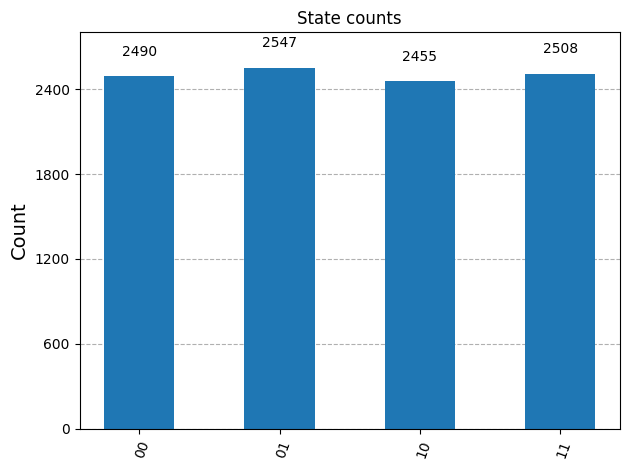

In [19]:
result = simulator.run(circ,shots=10000).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='State counts')

In [20]:
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0,1)
circ.measure_all()
print(circ)

        ┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1 


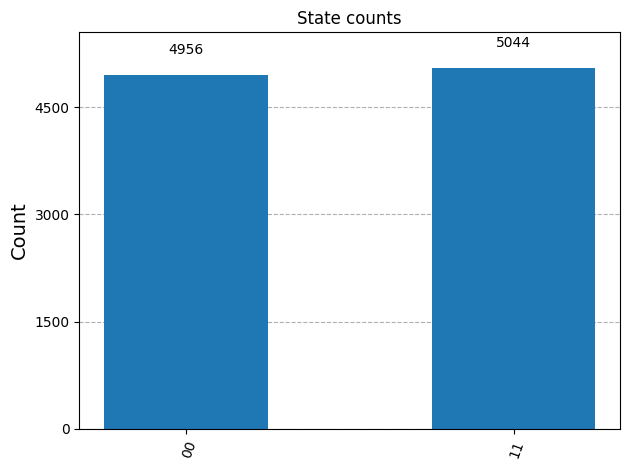

In [21]:
result = simulator.run(circ,shots=10000).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='State counts')

### Some potential rough patches with quantum programming
- Limited 'quantum volume' of real experiments
    - Defined as $2^n$ for the largest $n$ that doesn't give garbage for 'square' circuits
- Debugging can be _really_ tough.
    - Depends heavily on analysis and visualization tools and how well you plan to test
    - The information is diffuse in the system
    - Noise + a lot of steps in the pipeline between your keyboard and the device

---
## Superdense coding

Image from https://mareknarozniak.com/2020/06/09/simulating-superdense-coding/

<img src="superdense-coding.png" width="600" style="margin:auto"/>

We're going to use four entangled pairs of qubits to relay one byte of data at a time. We'll be able to decode $n$ bytes by running **$\frac{n}{2}$ different 8-qubit quantum circuits**!

Alice wants to send Bob an email, but also has a 2 billion dollar research budget.
How can Alice spend as much money as possible in the name of efficiency? With superdense coding!

1. Alice hires an undergrad named Charlie to press literally two buttons (on demand, this is where the big bucks are) to **entangle** pairs of qubits. 

2. Charlie carefully packs one qubit from each pair up for Bob, taking care not to drop it or let it decohere. Alice gets the other qubit, and **secretly applies one of $I$, $Z$, $X$, or $ZX$ to that qubit, then Alice sends the modified qubit to Bob** too.

3. Bob has the qubits *from both* Charlie and Alice now, and can decode the email with a team of post-docs and liberal application of a **bell state measurement**.

In [22]:
# Set a mapping for qubits to give to Alice and Bob
to_bob = [2*i for i in range(4)] # evens
to_alice = [2*i+1 for i in range(4)] # odds

# Charlie is our entanglement source.
# Press the button, Charlie.
def charlie(qc, to_alice, to_bob):
    qc.reset(range(8))
    qc.h(to_alice)
    qc.cx(to_alice,to_bob)
   
    

# Alice encodes byte by byte, four 'crumbs' at a time.
# (a crumb is a pair of bits; not quite a nibble and much less than a byte)
def alice(qc, byte, to_alice):

    # A crumb is the word for 2 bits!
    crumbs = ['11','10','01','00'] # Alice's message
    
    # cidx for 'crumb index'
    for cidx in range(4):
        if crumbs[cidx] == '11':
            qc.x(to_alice[cidx])
            qc.z(to_alice[cidx])
        elif crumbs[cidx] == '10':
            qc.x(to_alice[cidx])
        elif crumbs[cidx] == '01':
            qc.z(to_alice[cidx])
        elif crumbs[cidx] == '00':
            pass

            
def bob(qc, to_alice, to_bob):
    qc.cx(to_alice,to_bob)
    qc.h(to_alice)

In [23]:
# Write the quantum circuit
qc = qiskit.QuantumCircuit(8)

charlie(qc, to_alice, to_bob)
qc.barrier()
print("Circuit after Charlie:")
print(qc)

Circuit after Charlie:
               ┌───┐ ░ 
q_0: ─|0>──────┤ X ├─░─
          ┌───┐└─┬─┘ ░ 
q_1: ─|0>─┤ H ├──■───░─
          └───┘┌───┐ ░ 
q_2: ─|0>──────┤ X ├─░─
          ┌───┐└─┬─┘ ░ 
q_3: ─|0>─┤ H ├──■───░─
          └───┘┌───┐ ░ 
q_4: ─|0>──────┤ X ├─░─
          ┌───┐└─┬─┘ ░ 
q_5: ─|0>─┤ H ├──■───░─
          └───┘┌───┐ ░ 
q_6: ─|0>──────┤ X ├─░─
          ┌───┐└─┬─┘ ░ 
q_7: ─|0>─┤ H ├──■───░─
          └───┘      ░ 


In [24]:
# Test all four crumbs, 00 01 10 11, at once
b = bytearray([0b00011011])
alice(qc, b[0], to_alice)
qc.barrier()
print("Circuit after Alice:")
print(qc)

Circuit after Alice:
               ┌───┐ ░            ░ 
q_0: ─|0>──────┤ X ├─░────────────░─
          ┌───┐└─┬─┘ ░ ┌───┐┌───┐ ░ 
q_1: ─|0>─┤ H ├──■───░─┤ X ├┤ Z ├─░─
          └───┘┌───┐ ░ └───┘└───┘ ░ 
q_2: ─|0>──────┤ X ├─░────────────░─
          ┌───┐└─┬─┘ ░ ┌───┐      ░ 
q_3: ─|0>─┤ H ├──■───░─┤ X ├──────░─
          └───┘┌───┐ ░ └───┘      ░ 
q_4: ─|0>──────┤ X ├─░────────────░─
          ┌───┐└─┬─┘ ░ ┌───┐      ░ 
q_5: ─|0>─┤ H ├──■───░─┤ Z ├──────░─
          └───┘┌───┐ ░ └───┘      ░ 
q_6: ─|0>──────┤ X ├─░────────────░─
          ┌───┐└─┬─┘ ░            ░ 
q_7: ─|0>─┤ H ├──■───░────────────░─
          └───┘      ░            ░ 


In [25]:
bob(qc, to_alice, to_bob)
# measure_all applies a barrier()
qc.measure_all()
print("Circuit after Bob:")
print(qc)

Circuit after Bob:
                  ┌───┐ ░            ░ ┌───┐      ░ ┌─┐                     
   q_0: ─|0>──────┤ X ├─░────────────░─┤ X ├──────░─┤M├─────────────────────
             ┌───┐└─┬─┘ ░ ┌───┐┌───┐ ░ └─┬─┘┌───┐ ░ └╥┘┌─┐                  
   q_1: ─|0>─┤ H ├──■───░─┤ X ├┤ Z ├─░───■──┤ H ├─░──╫─┤M├──────────────────
             └───┘┌───┐ ░ └───┘└───┘ ░ ┌───┐└───┘ ░  ║ └╥┘┌─┐               
   q_2: ─|0>──────┤ X ├─░────────────░─┤ X ├──────░──╫──╫─┤M├───────────────
             ┌───┐└─┬─┘ ░ ┌───┐      ░ └─┬─┘┌───┐ ░  ║  ║ └╥┘┌─┐            
   q_3: ─|0>─┤ H ├──■───░─┤ X ├──────░───■──┤ H ├─░──╫──╫──╫─┤M├────────────
             └───┘┌───┐ ░ └───┘      ░ ┌───┐└───┘ ░  ║  ║  ║ └╥┘┌─┐         
   q_4: ─|0>──────┤ X ├─░────────────░─┤ X ├──────░──╫──╫──╫──╫─┤M├─────────
             ┌───┐└─┬─┘ ░ ┌───┐      ░ └─┬─┘┌───┐ ░  ║  ║  ║  ║ └╥┘┌─┐      
   q_5: ─|0>─┤ H ├──■───░─┤ Z ├──────░───■──┤ H ├─░──╫──╫──╫──╫──╫─┤M├──────
             └───┘┌───┐ ░ └───┘      ░ ┌───┐└───┘ ░  ║  ║

In [26]:
# Noiseless simulation
job = simulator.run(qc, shots=1)
result = job.result()
for key, count in result.get_counts().items():
    message = [key[0:2], key[2:4], key[4:6], key[6:8]]
    print(f'Message: {message}, Count: {count}')

result # view all the information in the result object

Message: ['00', '10', '01', '11'], Count: 1


Result(backend_name='aer_simulator', backend_version='0.17.0', job_id='434e9da1-c4e9-408e-b98d-88acb5c17952', success=True, results=[ExperimentResult(shots=1, success=True, meas_level=2, data=ExperimentResultData(counts={'0x27': 1}), header={'creg_sizes': [['meas', 8]], 'global_phase': 0.0, 'memory_slots': 8, 'n_qubits': 8, 'name': 'circuit-166', 'qreg_sizes': [['q', 8]], 'metadata': {}}, status=DONE, seed_simulator=2545024872, metadata={'time_taken': 7.75e-05, 'num_bind_params': 1, 'parallel_state_update': 12, 'required_memory_mb': 0, 'input_qubit_map': [[7, 7], [6, 6], [5, 5], [4, 4], [3, 3], [2, 2], [1, 1], [0, 0]], 'method': 'stabilizer', 'device': 'CPU', 'num_qubits': 8, 'active_input_qubits': [0, 1, 2, 3, 4, 5, 6, 7], 'num_clbits': 8, 'remapped_qubits': False, 'parallel_shots': 1, 'runtime_parameter_bind': False, 'max_memory_mb': 15961, 'noise': 'ideal', 'measure_sampling': False, 'batched_shots_optimization': False, 'fusion': {'enabled': False}}, time_taken=7.75e-05)], date=2025

## Quantum Teleportation

Image from https://mareknarozniak.com/2020/03/22/simulating-quantum-teleportation/


<img src="teleportation-circuit.png" width="600" style="margin:auto"/>

In [27]:
from qiskit import QuantumRegister, ClassicalRegister
qubit = QuantumRegister(3, name="our_qubits") 
creg = ClassicalRegister(2, name="our_classicals")
qc = QuantumCircuit(qubit,creg)

# Select a state for psi!
qc.id(qubit[0]) # Leave it in the |0> state
qc.barrier()

qc.h(qubit[1])
qc.cx(qubit[1], qubit[2]) # qubit 1 is now entangled with qubit 2
qc.barrier()

qc.cx(qubit[0], qubit[1])
qc.h(qubit[0])
qc.barrier()
qc.measure(qubit[0:2], creg) # bell state measurement of qubit 0
qc.barrier()

qc.x(qubit[2]).c_if(creg[1], 1) # Apply gates if the registers are in the state '1'
qc.z(qubit[2]).c_if(creg[0], 1) 

print(qc)

AttributeError: 'InstructionSet' object has no attribute 'c_if'



## Bonus: W - State
The W state is an entangled quantum state of three qubits which in the bra-ket notation has the following shape
$$
\ket{W} = \frac{1}{\sqrt{3}} (\ket{001}+ \ket{010}+ \ket{100})
$$

The notion of W state has been generalized for n qubits and then refers to the quantum superposition with equal expansion coefficients of all possible pure states in which exactly one of the qubits is in an "excited state" 
$$
\ket{W}_n = \frac{1}{\sqrt{n}} (\ket{00...01}+ \ket{00...10}+ ... + \ket{10...00})
$$

$$
\ket{W}_1 = \ket{1}
$$

$$
\ket{W}_2 = \frac{1}{\sqrt{2}}(\ket{01}+ \ket{10})
$$

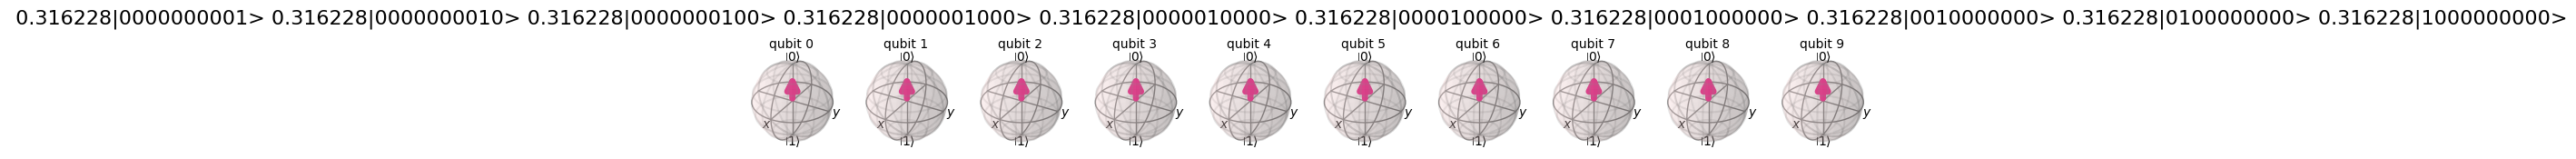

In [ ]:
n=10
array = [1/sqrt(10) if bin(i).count("1")==1 else 0 for i in range(2**n)]

phi = Statevector(array)
plot_bloch_multivector(phi, title=get_braket_string(phi))
# for better plotting, try the qutip package: https://qutip.readthedocs.io/en/qutip-5.0.x/guide/guide-bloch.html

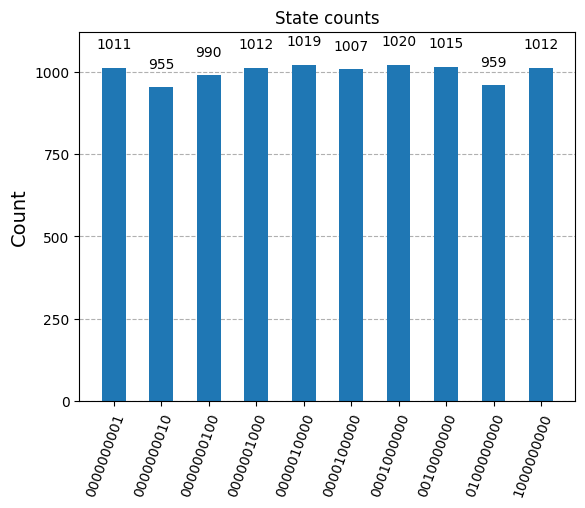

In [ ]:
init_gate = Initialize(phi)
init_gate.label = "init"

circ = QuantumCircuit(10)
circ.append(init_gate, range(10))
circ.measure_all()

result = simulator.run(circ,shots=10000).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='State counts')

Qiskit needs to decompose the initial gate `init_gate` into a sequence of hardware support gate before running it on the hardware, which is not scalable for large `N`. Suppose `N=64`, it need to decompose a $2^{64} \times 2^{64}$ matrix!

Food for thought: 

 1. Consider the tripartite (3-qubit) W and GHZ states. It is known that W is more robust as an entangled state. Why is that?

 2. How to implement a Qiskit function that can produce a $\ket{W}_N$ state preparation circuit for large $N, N=2^n$?

Hint: Think about the program in a recursive way. You need one ancilla qubit.






<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>

------------------------------





Answer

The program uses qubit 0 as an ancilla qubit and proceeds by induction on variable $n$ to create W-state over qubit $1,2,...,2^{n-1}$. 

1. Suppose $N=2^{n-1}$. When $n=1$, it just applies Pauli X gate on qubit 1 to create state $\ket{W_1} = \ket{1}$. 

2. For general $n > 1$, it first calls itself recursively to create W-state $\ket{W_{N/2}}$ on the qubits $1,2,...,N/2$. By now, the qubits $1,2,...,N/2$ are already in a superposition where only basis states of Hamming weight 1 occur. 

3. Next, it flip the ancilla qubit from $\ket{0} \mapsto \frac{1}{\sqrt{2}}(\ket{0} + \ket{1})$ and this ancilla will serve as a flag whether we are in the block of the first $N/2$ qubits or the block of the last $N/2$ qubits.
4.  If the flag is “0”, there is nothing to be done.
5.  If the flag is “1”, it moves the state of the first $N/2$ qubits to the state of the last $N/2$ qubits and vice versa. This is
accomplished using a sequence of controlled SWAP operation implemented in the sub-program $S'$. This almost creates the state $\ket{W_N}$ on qubits $1,2,...,N$. However, one issue remains: the state is now entangled with the state of qubit 0.
6. So the program $S'$ uses a sequence of `CNOT` gate to reset qubit 0.

In [ ]:
def wstate(circ,n):
    # use qubit 0 as the ancilla qubit
    if n==1:
        circ.x(1)
        return
    wstate(circ, n//2)
    circ.h(0)
    for i in range(1,n//2+1):
        circ.cswap(0, i, i+n//2)
    for i in range(1,n//2+1):
        circ.cx(i+n//2,0)


         ┌───┐   ┌───┐┌───┐      ┌───┐┌───┐┌───┐            ┌───┐┌───┐┌───┐»
    q_0: ┤ H ├─■─┤ X ├┤ H ├─■──■─┤ X ├┤ X ├┤ H ├─■──■──■──■─┤ X ├┤ X ├┤ X ├»
         ├───┤ │ └─┬─┘└───┘ │  │ └─┬─┘└─┬─┘└───┘ │  │  │  │ └─┬─┘└─┬─┘└─┬─┘»
    q_1: ┤ X ├─X───┼────────X──┼───┼────┼────────X──┼──┼──┼───┼────┼────┼──»
         └───┘ │   │        │  │   │    │        │  │  │  │   │    │    │  »
    q_2: ──────X───■────────┼──X───┼────┼────────┼──X──┼──┼───┼────┼────┼──»
                            │  │   │    │        │  │  │  │   │    │    │  »
    q_3: ───────────────────X──┼───■────┼────────┼──┼──X──┼───┼────┼────┼──»
                               │        │        │  │  │  │   │    │    │  »
    q_4: ──────────────────────X────────■────────┼──┼──┼──X───┼────┼────┼──»
                                                 │  │  │  │   │    │    │  »
    q_5: ────────────────────────────────────────X──┼──┼──┼───■────┼────┼──»
                                                    │  │  │        │    │  »

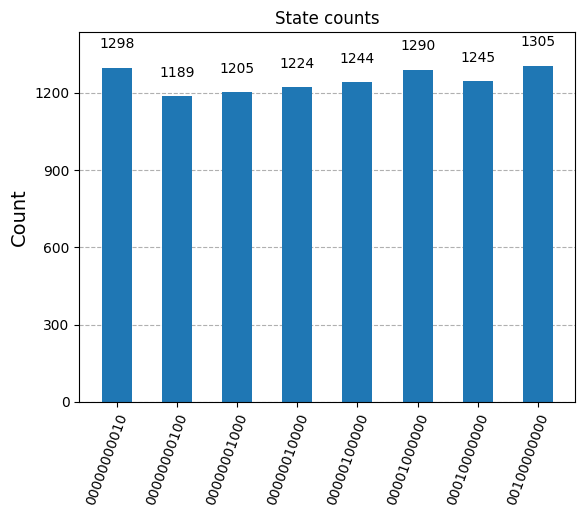

In [ ]:
circ = QuantumCircuit(11)
wstate(circ, 8)
circ.measure_all()
print(circ)

result = simulator.run(circ,shots=10000).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='State counts')

You can find how to produce general construction W-state [here](https://quantumcomputing.stackexchange.com/questions/4350/general-construction-of-w-n-state)